SETUP AND CONFIGURATION

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity


# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running Benchmark on: {device.type.upper()}")

# The 4 Models to Compare
models_config = [
    # The Baseline (Standard BERT)
    {"name": "bert-base-uncased", "type": "standard", "label": "BERT (Standard)"},
    # The "Raw" Competitor
    {"name": "roberta-base", "type": "standard", "label": "RoBERTa (Standard)"},
    # The Fast Winner
    {"name": "sentence-transformers/all-MiniLM-L6-v2", "type": "sbert", "label": "SBERT (MiniLM)"},
    # The Smartest Winner
    {"name": "sentence-transformers/all-mpnet-base-v2", "type": "sbert", "label": "SBERT (MPNet)"}
]

# Thesis Data Points
job_desc = "Looking for a Software Engineer with Python and Machine Learning experience. Must know PyTorch and AWS."

resumes = [
    {
        "role": "Perfect Match (Senior)", 
        "text": "Senior ML Engineer with 6 years experience in Python, PyTorch, and cloud deployment on AWS. Deployed NLP models to production."
    },
    {
        "role": "Recruiter (The Trap)", 
        "text": "Technical Recruiter. I hire Python developers and Machine Learning engineers. I know what AWS and PyTorch are."
    },
    {
        "role": "Java Dev (Wrong Tech)", 
        "text": "Senior Backend Software Engineer. 10 years of experience in Java, Spring Boot, and Microservices. Willing to learn Python."
    },
    {
        "role": "Chef (Irrelevant)", 
        "text": "Head Chef with 10 years of experience managing kitchen staff, menu planning, and inventory management."
    }
]



Running Benchmark on: CUDA


SCORING ENGINE


In [14]:

class StandardModelScorer:
    """Handles raw BERT/RoBERTa models with manual Mean Pooling"""
    def __init__(self, model_name, device):
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
    
    def get_score(self, text1, text2):
        inputs = self.tokenizer([text1, text2], padding=True, truncation=True, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        # Mean Pooling Logic
        embeddings = outputs.last_hidden_state
        attention_mask = inputs['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
        sum_embeddings = torch.sum(embeddings * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        pooled = sum_embeddings / sum_mask
        
        return float(cosine_similarity([pooled[0].cpu().numpy()], [pooled[1].cpu().numpy()])[0][0])

class SBertScorer:
    """Handles Sentence-BERT models (optimized)"""
    def __init__(self, model_name, device):
        self.model = SentenceTransformer(model_name, device=str(device))
    
    def get_score(self, text1, text2):
        embeddings = self.model.encode([text1, text2], convert_to_tensor=True)
        return float(util.cos_sim(embeddings[0], embeddings[1]).item())

EXECUTION LOOP

In [15]:

results = []

print("\n>>> Starting Model Comparison Loop...")

for config in models_config:
    print(f"Processing Model: {config['label']}...")
    
    # Initialize appropriate scorer
    if config['type'] == "standard":
        scorer = StandardModelScorer(config['name'], device)
    else:
        scorer = SBertScorer(config['name'], device)
    
    # Score all resumes
    for res in resumes:
        score = scorer.get_score(res['text'], job_desc)
        results.append({
            "Model": config['label'],
            "Resume Type": res['role'],
            "Relevance Score": score
        })
    
    # Cleanup memory
    del scorer
    torch.cuda.empty_cache()



>>> Starting Model Comparison Loop...
Processing Model: BERT (Standard)...
Processing Model: RoBERTa (Standard)...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing Model: SBERT (MiniLM)...
Processing Model: SBERT (MPNet)...


VISUALIZATION


>>> Generating Visualization...

✅ SUCCESS! Chart saved as 'thesis_model_comparison.png'

You can now insert this image directly into Chapter 4 (Results) of your thesis.


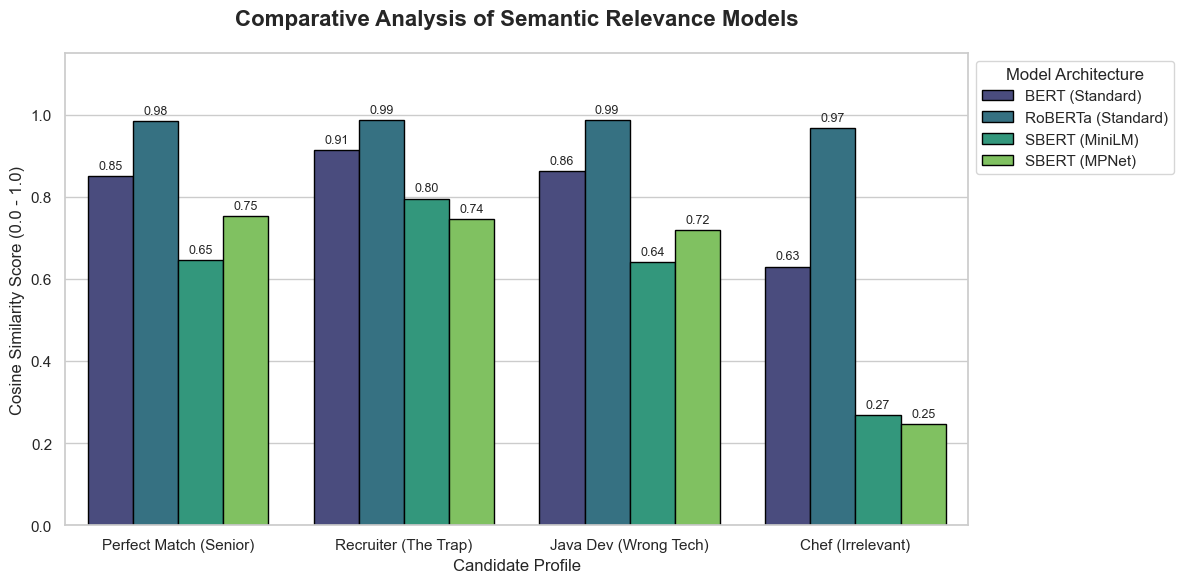

In [16]:
print("\n>>> Generating Visualization...")
df = pd.DataFrame(results)

# Set the visual style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create Grouped Bar Chart
chart = sns.barplot(
    data=df,
    x="Resume Type",
    y="Relevance Score",
    hue="Model",
    palette="viridis",
    edgecolor="black" # Adds border for crisp look
)

# Customizing the Thesis Look
plt.title("Comparative Analysis of Semantic Relevance Models", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Cosine Similarity Score (0.0 - 1.0)", fontsize=12)
plt.xlabel("Candidate Profile", fontsize=12)
plt.ylim(0, 1.15) # Leave room for labels
plt.legend(title="Model Architecture", bbox_to_anchor=(1.0, 1), loc='upper left')

# Add score labels on top of bars
for container in chart.containers:
    chart.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()

# Save as High-Res Image
filename = "thesis_model_comparison.png"
plt.savefig(filename, dpi=300)
print(f"\n✅ SUCCESS! Chart saved as '{filename}'")
print("\nYou can now insert this image directly into Chapter 4 (Results) of your thesis.")

In [5]:
import torch
from sentence_transformers import SentenceTransformer, util

class BertRelevanceScorer:
    def __init__(self, model_name='sentence-transformers/all-mpnet-base-v2'):
        """
        Using 'all-mpnet-base-v2' (The 'Smartest' Model)
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Loading Relevance Model on: {self.device.upper()}")
        print(f"Model: {model_name} (Downloading/Loading... this might take a moment)")
        
        self.model = SentenceTransformer(model_name, device=self.device)

    def calculate_relevance(self, resume_text, job_description):
        embedding_resume = self.model.encode(resume_text, convert_to_tensor=True)
        embedding_job = self.model.encode(job_description, convert_to_tensor=True)
        similarity = util.cos_sim(embedding_resume, embedding_job)
        return float(similarity.item())

# --- Extended Testing ---
if __name__ == "__main__":
    scorer = BertRelevanceScorer()
    
    # The Target Job
    job_desc = "We need a Senior Software Engineer to build scalable AI pipelines. "
    
    resumes = [
        {
            "role": "Ideally Qualified (The Unicorn)",
            "text": (
                "Staff ML Engineer with 7 years of experience. I architected a real-time recommendation system "
                "using Python and PyTorch on AWS SageMaker. Expert in Dockerizing models and setting up "
                "Jenkins CI/CD pipelines for automated retraining."
            )
        },
        {
            "role": "The Academic (Theory vs. Practice)",
            "text": (
                "PhD in Computer Vision. Published 5 papers on Deep Learning optimization. "
                "Extensive experience with MATLAB and prototype coding in PyTorch. "
                "Looking to transition from academia to industry. No cloud experience."
            )
        },
        {
            "role": "The Manager (The 'I Led' Trap)",
            "text": (
                "Engineering Manager. I led a team of 10 Software Engineers building Python microservices "
                "and PyTorch models on AWS. I managed the roadmap, sprint planning, and stakeholder communication. "
                "I haven't written code in 5 years."
            )
        },
        {
            "role": "The Keyword Stuffer (Low Quality)",
            "text": (
                "Python, Java, C++, AWS, Azure, Google Cloud, PyTorch, TensorFlow, Keras, "
                "Machine Learning, Deep Learning, AI, Docker, Kubernetes, React, Angular, SQL, NoSQL. "
                "Hard worker looking for any job."
            )
        },
        {
            "role": "The Legacy Dev (Right Role / Wrong Era)",
            "text": (
                "Senior Systems Engineer with 15 years of experience in C and C++. "
                "Built high-frequency trading platforms. Expert in memory management and low-level optimization. "
                "Interested in learning modern AI tools."
            )
        },
        {
            "role": "The False Positive (Sales)",
            "text": (
                "Enterprise Sales Director for AWS. I sell Cloud and Machine Learning solutions "
                "to Fortune 500 companies. I speak fluent Python and PyTorch terminology "
                "to close deals with CTOs."
            )
        }
    ]
    
    print(f"Target Job: {job_desc}\n")
    print("-" * 65)
    print(f"{'ROLE':<35} | {'SCORE':<10} | {'STATUS'}")
    print("-" * 65)
    
    for res in resumes:
        score = scorer.calculate_relevance(res["text"], job_desc)
        
        if score > 0.65:
            status = "✅ High"
        elif score > 0.45:
            status = "⚠️ Medium"
        else:
            status = "❌ Low"
            
        print(f"{res['role']:<35} | {score:.4f}     | {status}")


Loading Relevance Model on: CUDA
Model: sentence-transformers/all-mpnet-base-v2 (Downloading/Loading... this might take a moment)
Target Job: We need a Senior Software Engineer to build scalable AI pipelines. 

-----------------------------------------------------------------
ROLE                                | SCORE      | STATUS
-----------------------------------------------------------------
Ideally Qualified (The Unicorn)     | 0.5349     | ⚠️ Medium
The Academic (Theory vs. Practice)  | 0.4903     | ⚠️ Medium
The Manager (The 'I Led' Trap)      | 0.3705     | ❌ Low
The Keyword Stuffer (Low Quality)   | 0.4686     | ⚠️ Medium
The Legacy Dev (Right Role / Wrong Era) | 0.5948     | ⚠️ Medium
The False Positive (Sales)          | 0.4006     | ❌ Low
